# HAI-21.03 Dataset Analysis with Simplified LSTM

This notebook implements a simplified LSTM approach with a larger sliding window (192 time steps) for analyzing the HAI-21.03 industrial control system security dataset. All implementation details are in the `simplified_lstm_utils.py` module.

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom modules
from hai_data_processor import HAIDataProcessor
import simplified_lstm_utils as utils

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

## 1. Global Variables Setup

Set up all global variables, including paths, parameters, and configurations.

In [2]:
# Set paths
DATA_DIR = 'hai-security-dataset/hai-21.03'
OUTPUT_DIR = 'hai-security-dataset/processed'
MODEL_DIR = 'models/simplified_global_en'

# Create model directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Set model parameters
SEQ_LENGTH = 128  # Sequence length (time steps)
STRIDE = 10        # Sliding window stride
N_COMPONENTS = 20 # Number of PCA components
N_FEATURES = 50   # Number of features to select
CORRELATION_THRESHOLD = 0.7  # Graph edge correlation threshold
MIN_ANOMALY_LENGTH = 30      # Minimum anomaly length
GAP_THRESHOLD = 3            # Maximum gap to merge anomalies

# Set training parameters
EPOCHS = 5
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
PATIENCE = 5
LEARNING_RATE = 0.001

# Set anomaly detection parameters
ANOMALY_SCORE_THRESHOLD = 0.65  # Anomaly score threshold
CONTAMINATION = 0.005           # Contamination rate for dynamic threshold

# Create parameters dictionary
PARAMS = {
    'model_dir': MODEL_DIR,
    'seq_length': SEQ_LENGTH,
    'stride': STRIDE,
    'n_components': N_COMPONENTS,
    'n_features': N_FEATURES,
    'correlation_threshold': CORRELATION_THRESHOLD,
    'min_anomaly_length': MIN_ANOMALY_LENGTH,
    'gap_threshold': GAP_THRESHOLD,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'validation_split': VALIDATION_SPLIT,
    'patience': PATIENCE,
    'learning_rate': LEARNING_RATE,
    'anomaly_score_threshold': ANOMALY_SCORE_THRESHOLD,
    'contamination': CONTAMINATION
}

## 2. Data Loading and Processing

Load the HAI-21.03 dataset and perform initial processing.

In [3]:
# Initialize data processor
processor = HAIDataProcessor(DATA_DIR, OUTPUT_DIR)

# Load data
processor.load_data()

# Get all training data and merge
train_df = processor.merge_train_data()

# Print dataset information
print(f"Training data shape: {train_df.shape}")
print(f"Training data columns: {train_df.columns[:10].tolist()}...")

# Get test dataset information
print("\nTest datasets:")
for name, df in processor.test_data.items():
    print(f"  {name}: {df.shape}")

Found 3 train files and 5 test files
Loading train files: 

Loading train files:  33%|███▎      | 1/3 [00:02<00:05,  2.59s/it]

train1: 216001 rows, 84 columns


Loading train files:  67%|██████▋   | 2/3 [00:05<00:02,  2.74s/it]

train2: 226801 rows, 84 columns


Loading train files: 100%|██████████| 3/3 [00:10<00:00,  3.63s/it]


train3: 478801 rows, 84 columns
Loading test files: 

Loading test files:  20%|██        | 1/5 [00:00<00:01,  2.00it/s]

test1: 43201 rows, 84 columns


Loading test files:  40%|████      | 2/5 [00:01<00:03,  1.01s/it]

test2: 118801 rows, 84 columns


Loading test files:  60%|██████    | 3/5 [00:03<00:02,  1.13s/it]

test3: 108001 rows, 84 columns


Loading test files:  80%|████████  | 4/5 [00:03<00:00,  1.15it/s]

test4: 39601 rows, 84 columns


Loading test files: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

test5: 92401 rows, 84 columns


Merged training data: 921603 rows, 84 columns
Training data shape: (921603, 84)
Training data columns: ['time', 'p1_b2004', 'p1_b2016', 'p1_b3004', 'p1_b3005', 'p1_b4002', 'p1_b4005', 'p1_b400b', 'p1_b4022', 'p1_fcv01d']...

Test datasets:
  test1: (43201, 84)
  test2: (118801, 84)
  test3: (108001, 84)
  test4: (39601, 84)
  test5: (92401, 84)


## 3. Graph Structure Creation

Create a graph structure to understand the relationships between different components.

Number of nodes: 87
Number of edges: 180

Node types:
  subsystem: 4
  component: 79
Showing subgraph with 50 nodes and 146 edges


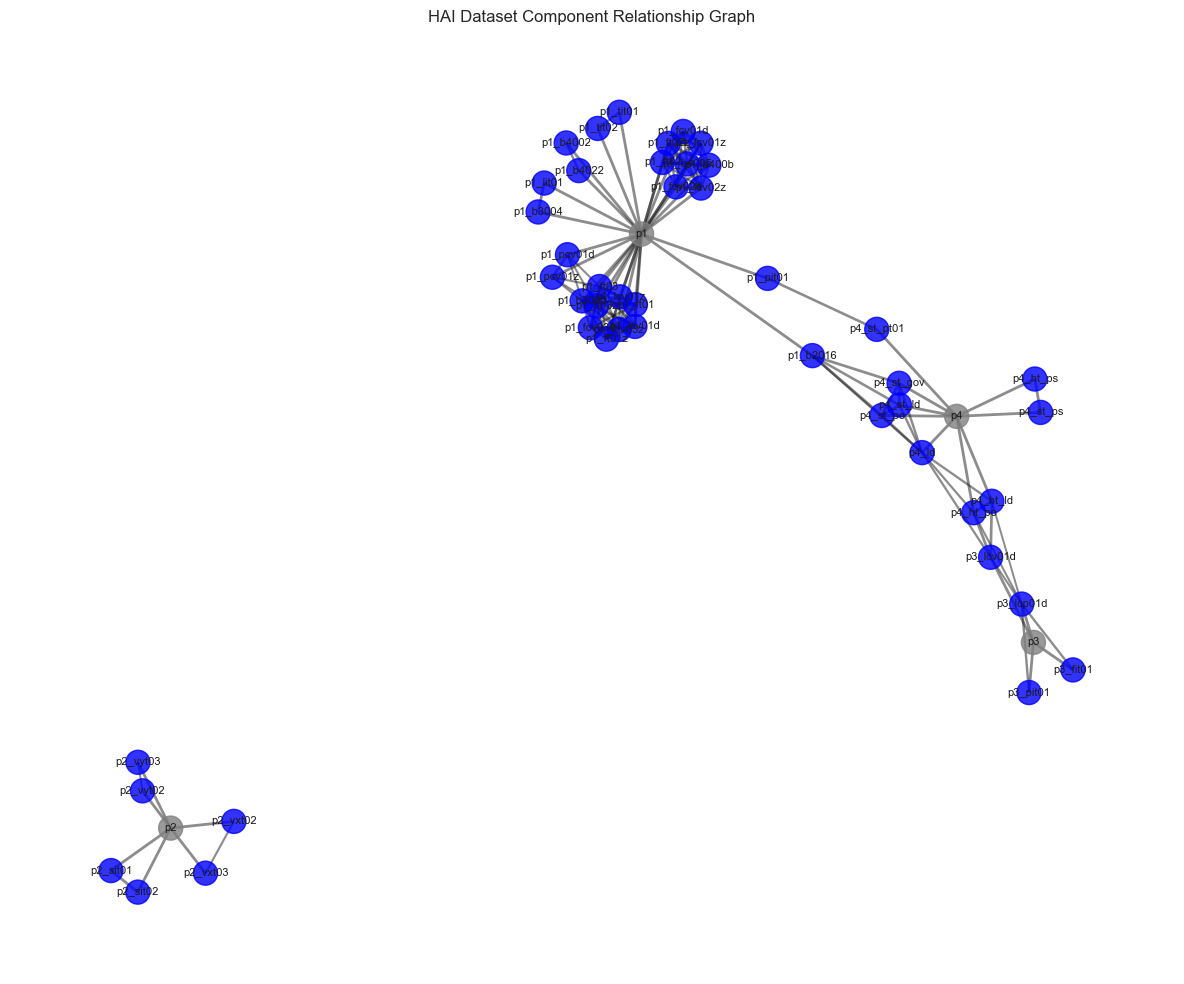

In [4]:
# Create graph
G = utils.create_graph_from_columns(train_df, CORRELATION_THRESHOLD)

# Print graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Safely count node types
node_types_count = {}
for _, data in G.nodes(data=True):
    if 'type' in data:
        node_type = data['type']
        if node_type not in node_types_count:
            node_types_count[node_type] = 0
        node_types_count[node_type] += 1

print(f"\nNode types:")
for node_type, count in node_types_count.items():
    print(f"  {node_type}: {count}")

# Visualize graph
utils.visualize_graph(G)

## 4. Feature Engineering and Model Training

Apply feature engineering, train the model, and evaluate on a single test file.

Original train features: 84
Processed train features: 84
New features added: 0

Processing test file: test1
Explained variance ratio: 0.9988
Selected 50 features out of 82
Epoch 1/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 13.6073

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 101s 76ms/step - loss: 13.6032 - val_loss: 3.0673 - learning_rate: 0.0010
Epoch 2/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.0813

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 83s 72ms/step - loss: 4.0812 - val_loss: 2.6426 - learning_rate: 0.0010
Epoch 3/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.8117

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 93s 81ms/step - loss: 3.8117 - val_loss: 2.5210 - learning_rate: 0.0010
Epoch 4/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.6554

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 95s 82ms/step - loss: 3.6554 - val_loss: 2.4267 - learning_rate: 0.0010
Epoch 5/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.5705

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 86s 75ms/step - loss: 3.5705 - val_loss: 2.3400 - learning_rate: 0.0010
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Precision: 0.6890
Recall: 0.7997
F1 Score: 0.7403
Accuracy: 0.9918
False Positive Rate: 0.0053
False Negative Rate: 0.2003


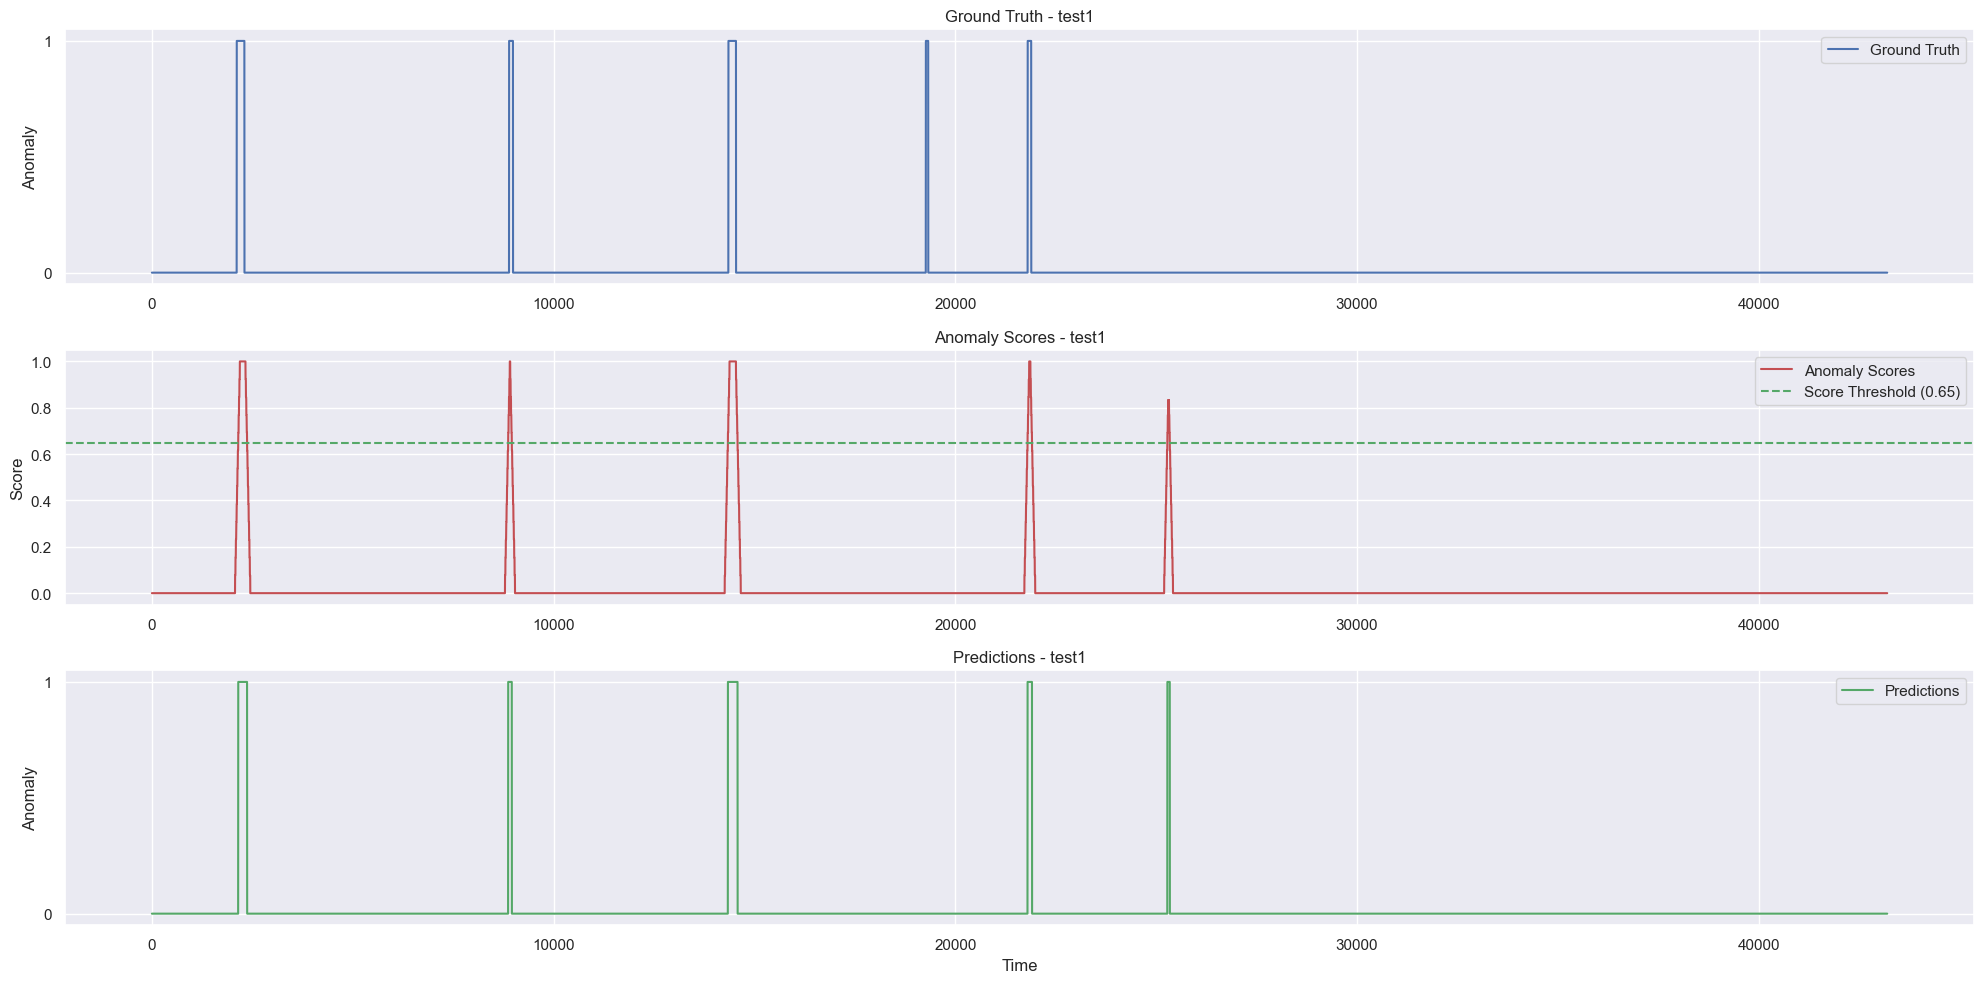

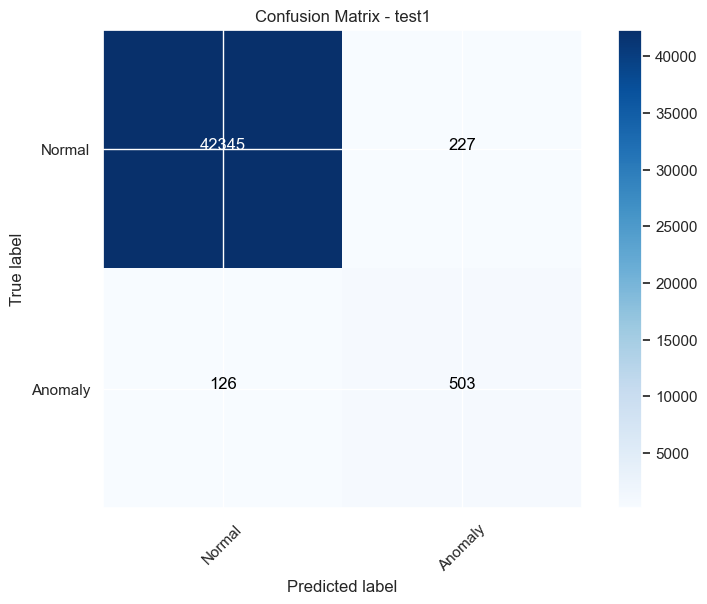

In [5]:
# Apply simplified graph feature engineering
train_df_processed = utils.simplified_graph_based_feature_engineering(train_df, G)

# Print feature counts
print(f"Original train features: {train_df.shape[1]}")
print(f"Processed train features: {train_df_processed.shape[1]}")
print(f"New features added: {train_df_processed.shape[1] - train_df.shape[1]}")

# Get first test file
test_name = list(processor.test_data.keys())[0]
test_df = processor.test_data[test_name]

# Run complete pipeline for first test file
result = utils.run_complete_pipeline(processor, train_df, test_name, test_df, PARAMS)

## 5. Evaluate on All Test Files

Evaluate the model on all test files.


Processing test file: test1
Explained variance ratio: 0.9988
Selected 50 features out of 82
Epoch 1/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 13.4158

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 92s 72ms/step - loss: 13.4117 - val_loss: 3.0954 - learning_rate: 0.0010
Epoch 2/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9910

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - loss: 3.9910 - val_loss: 2.8940 - learning_rate: 0.0010
Epoch 3/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.7669

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - loss: 3.7669 - val_loss: 2.8226 - learning_rate: 0.0010
Epoch 4/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.6844

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - loss: 3.6845 - val_loss: 2.7704 - learning_rate: 0.0010
Epoch 5/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.6267

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 80s 70ms/step - loss: 3.6268 - val_loss: 2.7049 - learning_rate: 0.0010
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Precision: 0.6792
Recall: 0.8315
F1 Score: 0.7477
Accuracy: 0.9918
False Positive Rate: 0.0058
False Negative Rate: 0.1685


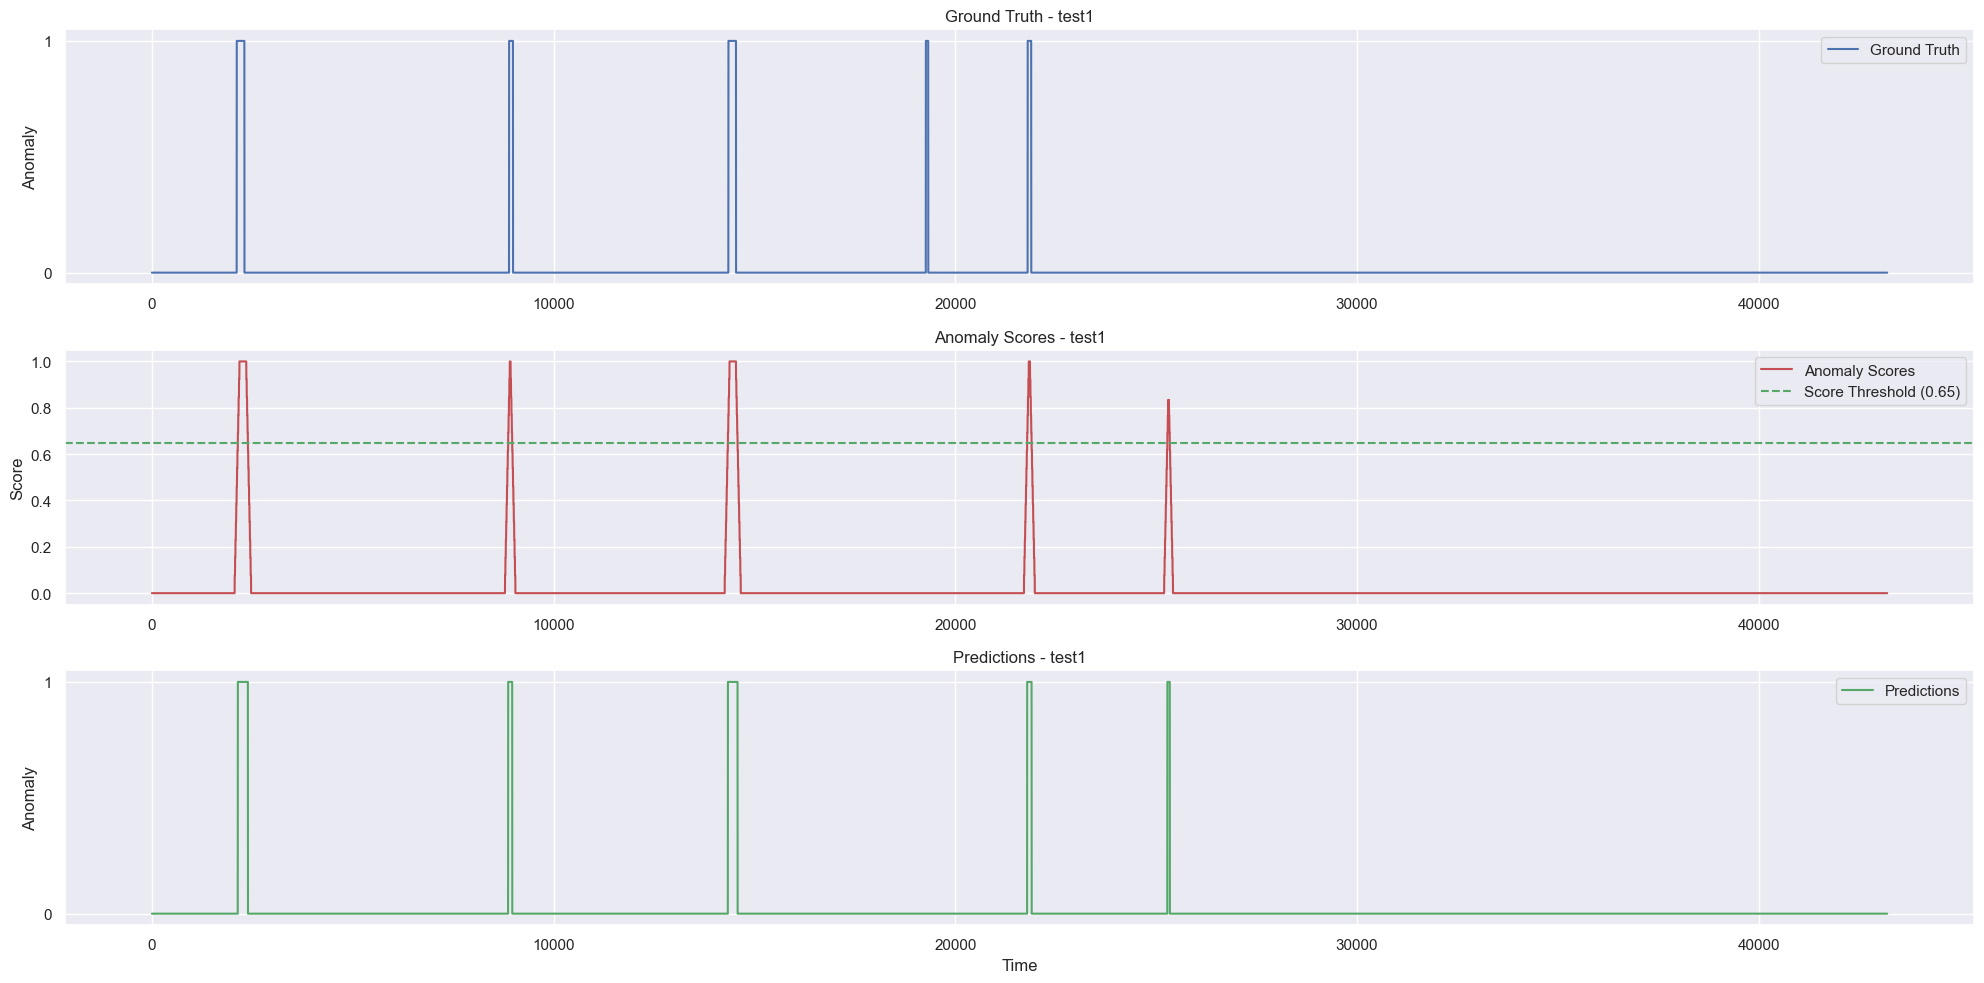

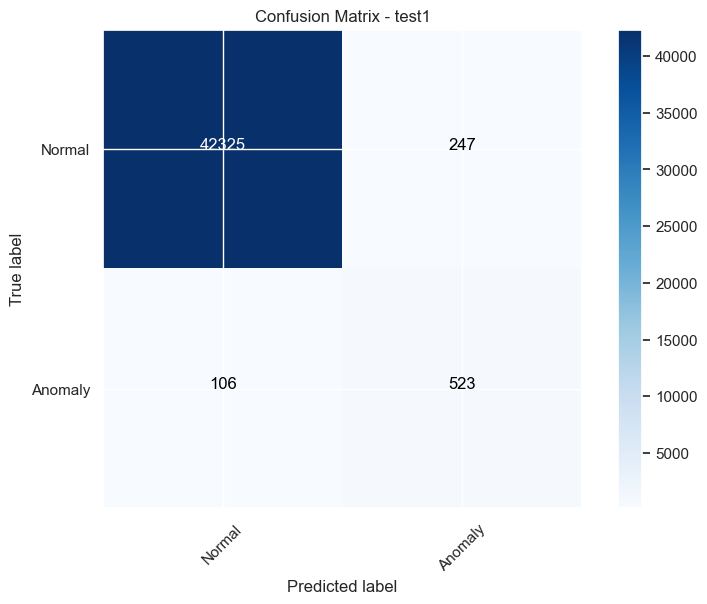


Processing test file: test2
Explained variance ratio: 0.9988
Selected 50 features out of 82
Epoch 1/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 14.0301

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - loss: 14.0258 - val_loss: 2.9046 - learning_rate: 0.0010
Epoch 2/5
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.9599

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 86s 75ms/step - loss: 3.9599 - val_loss: 2.5973 - learning_rate: 0.0010
Epoch 3/5
1075/1152 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 3.7348

KeyboardInterrupt: 

In [6]:
# Evaluate on all test files
results_df = utils.evaluate_on_all_test_files(processor, train_df, PARAMS)

# Display results
results_df

## 6. Visualize Results

Visualize the results across all test files.

In [ ]:
# Visualize metrics across test files
utils.visualize_metrics_comparison(results_df)

# Visualize error rates
utils.visualize_error_rates(results_df)

## 7. Compare with Previous Models

Compare our simplified LSTM model with previous models.

In [ ]:
# Compare with previous models
comparison_df = utils.compare_with_previous_models(results_df)

# Display comparison
comparison_df

In [ ]:
# Visualize comparison
utils.visualize_model_comparison(comparison_df)